In [2]:
import numpy as np
import pickle
import os
import rasterio
from pyproj import Transformer
import numpy as np
import matplotlib.pyplot as plt
import random
import geopandas as gpd
import pandas as pd
from shapely import wkt
from tqdm import tqdm
from typing import List
import torch
from torch.utils.data import Dataset


def show(data):
    """
    Inspect the structure of the 'data' dictionary.
    For each year, it prints the available keys, types, and shapes if applicable.
    """
    print("🔎 Exploring data structure\n" + "-"*60)
    for year_key, year_data in data.items():
        print(f"{year_key}")
        
        if not isinstance(year_data, dict):
            print(f"  ⚠️ Expected dict, got {type(year_data)}\n")
            continue
        
        # Loop through subkeys (like imgs_array, iris_index, etc.)
        for key, value in year_data.items():
            info = f"  ├─ {key:<25} → "
            
            # Describe arrays
            if isinstance(value, (list, tuple)):
                info += f"list[{len(value)}]"
            elif isinstance(value, dict):
                info += f"dict[{len(value)}]"
            elif hasattr(value, "shape"):
                info += f"array shape={value.shape}, dtype={getattr(value, 'dtype', 'N/A')}"
            else:
                info += str(type(value))
            
            print(info)
        
        print("-"*60)

def load(save_path):
    with open(save_path, "rb") as f:
       data = pickle.load(f)
    print("✅ Data loaded successfully!")

    return data

# Changing the structure of the dataset

In [67]:
def transform_to_patch_storing(data):
    data_patch = {}

    years = list(range(2013, 2022))   # 9 years
    num_patches = 500

    for patch_idx in range(num_patches):

        patch = {
            "years": years,
            "imgs": np.zeros((9, 128, 128, 3), dtype=np.uint8),
            "coords": np.zeros((9, 128, 128, 2), dtype=np.float32),
            "iris_index": np.zeros((9, 128, 128), dtype=object),
            "iris_patch_proportions": [None] * 9,
            "socioeco": np.zeros((9, 96), dtype=np.float64)
        }

        for year_idx, year in enumerate(years):
            year_data = data[str(year)]

            patch["imgs"][year_idx] = year_data["imgs_array"][patch_idx]
            patch["coords"][year_idx] = year_data["space_coordinates"][patch_idx]
            patch["iris_index"][year_idx] = year_data["iris_index"][patch_idx]
            patch["iris_patch_proportions"][year_idx] = year_data["iris_patch_proportions"][patch_idx]
            patch["socioeco"][year_idx] = year_data["socioeconomic_vector"][patch_idx]

        data_patch[patch_idx] = patch

    return data_patch

In [3]:
class TemporalPatch:
    def __init__(self, patch_id, data_patch):
        self.patch_id = patch_id

        # internal protected attributes (immutable from outside)
        self._years = list(data_patch[patch_id]['years'])                      # copy
        self._imgs = np.copy(data_patch[patch_id]['imgs'])                     # copy
        self._coords = np.copy(data_patch[patch_id]['coords'])                 # copy
        self._iris_index = np.copy(data_patch[patch_id]['iris_index'])         # copy
        self._iris_props = list(data_patch[patch_id]['iris_patch_proportions'])# shallow copy
        self._socioeco = np.copy(data_patch[patch_id]['socioeco'])             # copy

    # --------- READ-ONLY PROPERTIES ---------
    @property
    def years(self):
        return list(self._years)  # safe copy

    @property
    def imgs(self):
        return np.copy(self._imgs)  # safe copy

    @property
    def coords(self):
        return np.copy(self._coords)  # safe copy

    @property
    def iris_index(self):
        return np.copy(self._iris_index)  # safe copy

    @property
    def iris_props(self):
        return list(self._iris_props)  # safe copy

    @property
    def socioeco(self):
        return np.copy(self._socioeco)  # safe copy

    # --------- GET YEAR ---------
    def get_year(self, year):
        if year not in self._years:
            raise ValueError(f"Year {year} not available. Available: {self._years}")

        idx = self._years.index(year)

        # return copies → safe & immutable
        return {
            "img": np.copy(self._imgs[idx]),
            "coords": np.copy(self._coords[idx]),
            "iris_index": np.copy(self._iris_index[idx]),
            "iris_props": self._iris_props[idx],  # if dict/list, user gets a separate reference anyway
            "socioeco": np.copy(self._socioeco[idx])
        }

    # --------- GET RANGE ---------
    def get_range(self, start_year, end_year):
        if start_year not in self._years or end_year not in self._years:
            raise ValueError(f"Invalid year range {start_year}–{end_year}. Available: {self._years}")

        idx1 = self._years.index(start_year)
        idx2 = self._years.index(end_year) + 1

        return {
            "years": self._years[idx1:idx2].copy(),
            "imgs": np.copy(self._imgs[idx1:idx2]),
            "coords": np.copy(self._coords[idx1:idx2]),
            "iris_index": np.copy(self._iris_index[idx1:idx2]),
            "iris_props": self._iris_props[idx1:idx2].copy(),
            "socioeco": np.copy(self._socioeco[idx1:idx2]),
        }

    # --------- PLOTTING ---------
    def plot_across_years(self, years_subset=None):
        # Determine which years to plot
        if years_subset is None:
            years_subset = self._years

        indices = [self._years.index(y) for y in years_subset]
        imgs = self._imgs[indices]  # safe read-only view

        n = len(imgs)
        cols = 3
        rows = (n + cols - 1) // cols

        fig, axes = plt.subplots(rows, cols, figsize=(12, 4 * rows))
        axes = axes.flatten()

        for ax, img, year in zip(axes, imgs, years_subset):
            ax.imshow(img)
            ax.set_title(f"Year {year}")
            ax.axis("off")

        # Disable unused axes
        for ax in axes[n:]:
            ax.axis("off")

        plt.tight_layout()
        plt.show()

    # --------- UTILITIES ---------
    def __len__(self):
        return len(self._years)

    def __repr__(self):
        return f"TemporalPatch(id={self.patch_id}, years={len(self._years)})"


In [4]:
def create_and_save_patches(data_patch: dict, save_path: str) -> List["TemporalPatch"]:
    """
    Converts the raw `data_patch` dict into a typed list of TemporalPatch objects
    and saves them to a pickle file.

    Parameters
    ----------
    data_patch : dict
        Dictionary where keys = patch_id and values = yearly data for that patch.
    save_path : str
        Output .pkl file path.

    Returns
    -------
    List[TemporalPatch]
        The list of TemporalPatch objects that were created and saved.
    """

    # ---- Step 1: Build list of TemporalPatch objects ----
    patch_list: List[TemporalPatch] = [
        TemporalPatch(patch_id, data_patch) for patch_id in data_patch
    ]

    print(f"✔ Built {len(patch_list)} TemporalPatch objects.")

    # ---- Step 2: Validate ----
    for i, p in enumerate(patch_list):
        if not isinstance(p, TemporalPatch):
            raise TypeError(f"❌ patch_list[{i}] is not a TemporalPatch but {type(p)}")

    # ---- Step 3: Save to pickle ----
    with open(save_path, "wb") as f:
        pickle.dump(patch_list, f)

    print(f"✔ Saved dataset to: {save_path}")

    return patch_list

In [71]:
path = r"C:\Users\adamh\Desktop\Satelite_images\Toulouse_data.pkl"
data = load(path)
data_patch = transform_to_patch_storing(data)

# 3) Build TemporalPatch objects and save
patch_list = create_and_save_patches(
    data_patch,
    save_path="Toulouse.pkl"
)

✅ Data loaded successfully!
✔ Built 500 TemporalPatch objects.
✔ Saved dataset to: Toulouse.pkl


# Loading the Patches

In [5]:
def load_patches(path: str) -> List["TemporalPatch"]:
    with open(path, "rb") as f:
        patches = pickle.load(f)

    if not isinstance(patches, list):
        raise TypeError("Expected a list of TemporalPatch objects.")

    for i, p in enumerate(patches):
        if not isinstance(p, TemporalPatch):
            raise TypeError(
                f"Item {i} is not a TemporalPatch (got {type(p)})"
            )

    print(f"✔ Loaded {len(patches)} patches.")
    return patches

loaded_patches = load_patches("Bordeaux.pkl")

✔ Loaded 500 patches.


✔ Loaded patches summary
---------------------------
Number of patches: 500
Patch 0 representation: TemporalPatch(id=0, years=9)
Years available: [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]
Image sequence shape: (9, 128, 128, 3)
Socioeconomic shape: (9, 96)
---------------------------
✔ Plotting images across years for patch 0...


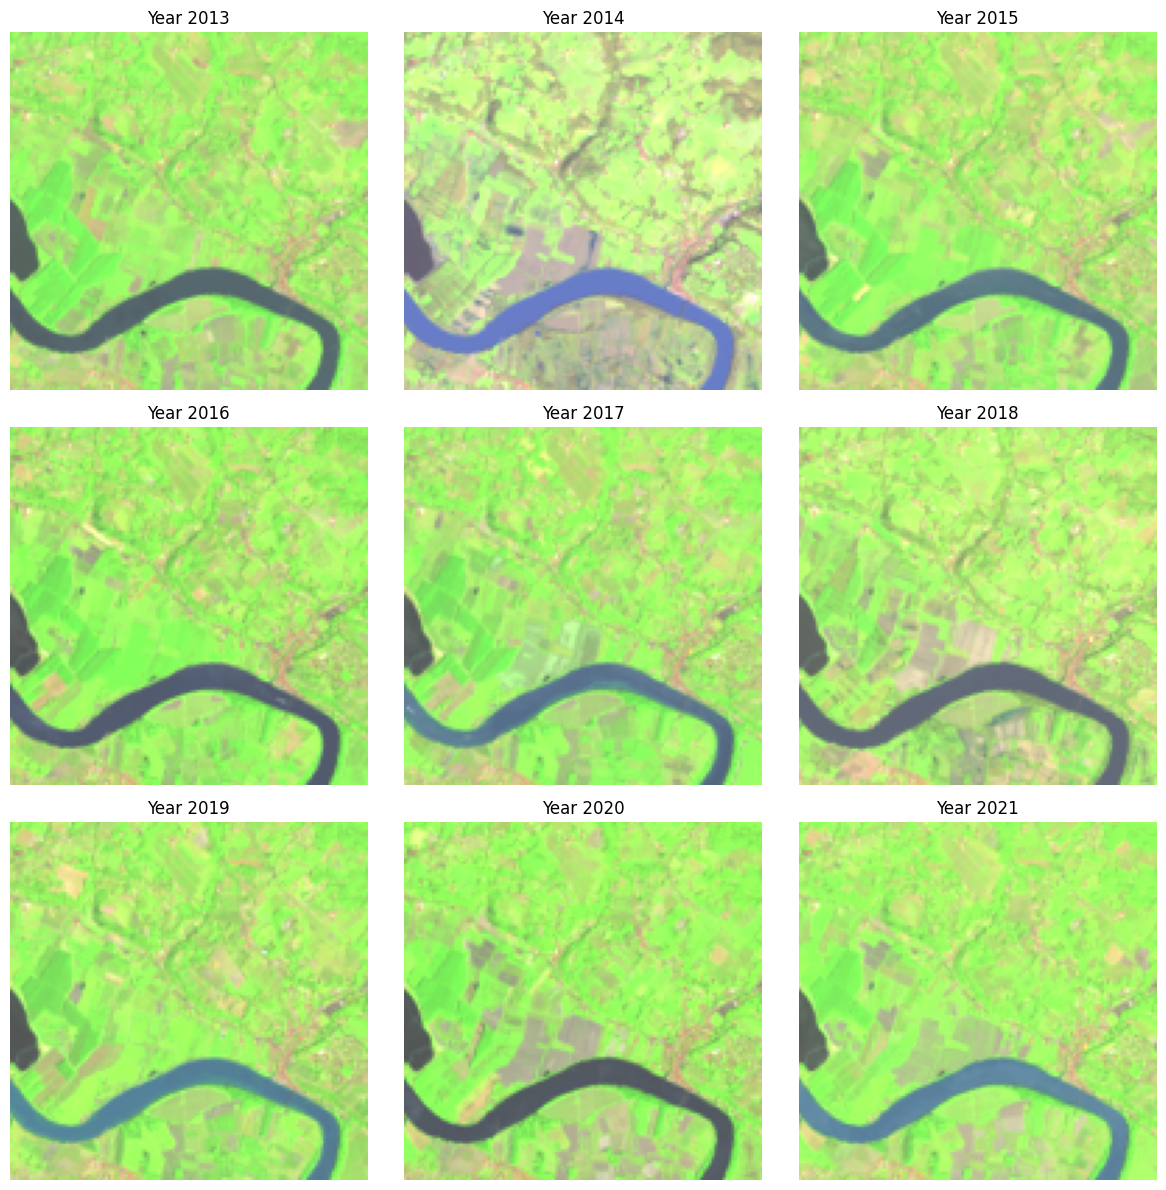

In [54]:
# Inspect first loaded patch
patch: TemporalPatch = loaded_patches[0]

print("✔ Loaded patches summary")
print("---------------------------")
print(f"Number of patches: {len(loaded_patches)}")
print(f"Patch 0 representation: {patch}")
print(f"Years available: {patch.years}")
print(f"Image sequence shape: {patch.imgs.shape}")   # (T, H, W, C)
print(f"Socioeconomic shape: {patch.socioeco.shape}")  # (T, 96)
print("---------------------------")

print("✔ Plotting images across years for patch 0...")
patch.plot_across_years()


# Using the dataset

In [32]:
class SatelliteTemporalDataset(Dataset):
    """
    Dataset for temporal forecasting using TemporalPatch objects.
    It returns (X_imgs, X_socioeco) → (y_img, y_socioeco).
    """

    def __init__(self, patches):
        """
        patches: List[TemporalPatch]
        input_length: number of past frames used as input
        forecast_horizon: how many steps ahead to predict (usually 1)
        """

        self.patches = patches



    def __len__(self):
        return len(self.samples)
    
    """
    def __getitem__(self, idx):
        p_idx, start = self.samples[idx]
        patch = self.patches[p_idx]

        # Convert to arrays (copies)
        imgs = patch.imgs        # shape (T,128,128,3)
        socio = patch.socioeco   # shape (T,96)

        # Input sequence
        X_imgs = imgs[start : start + self.input_length]
        X_socio = socio[start : start + self.input_length]

        # Target values (forecast step)
        y_imgs = imgs[start + self.input_length + self.forecast_horizon - 1]
        y_socio = socio[start + self.input_length + self.forecast_horizon - 1]

        # Convert to torch
        X_imgs = torch.tensor(X_imgs, dtype=torch.float32).permute(0,3,1,2)
        X_socio = torch.tensor(X_socio, dtype=torch.float32)
        y_imgs = torch.tensor(y_imgs, dtype=torch.float32).permute(2,0,1)
        y_socio = torch.tensor(y_socio, dtype=torch.float32)

        sample = {
            "X_imgs": X_imgs,
            "X_socio": X_socio,
            "y_img": y_imgs,
            "y_socio": y_socio,
            "patch_id": p_idx
        }

        if self.transform:
            sample = self.transform(sample)

        return sample
    """
    def __getitem__(self, idx):
        return self.patches[idx].imgs, self.patches[idx].socioeco
    
    def all(self):
        num_patches = len(self.patches)
        d = self.patches.socioeco.shape[0]
        patch = self.patches[0]
        num_years, H, W, C = patch.imgs.shape
        imgs = np.zeros(num_patches, num_years, H, W, C)
        vects_se = np.zeros(num_patches, num_years, d)

        for i, patch in enumerate(self.patches):
            imgs[i] = patch.imgs
            vects_se[i] = patch.socioeco

        return imgs, vects_se



In [11]:
# Load saved TemporalPatch objects
loaded_patches = load_patches("Bordeaux.pkl")

print("✔ Loaded patches")
print("---------------------------")
print("Number of patches:", len(loaded_patches))

# Inspect first patch
first_patch = loaded_patches[0]
print("First patch:", first_patch)
print("Years:", first_patch.years)
print("Image time-series shape:", first_patch.imgs.shape)
print("Socioeco time-series shape:", first_patch.socioeco.shape)


✔ Loaded 500 patches.
✔ Loaded patches
---------------------------
Number of patches: 500
First patch: TemporalPatch(id=0, years=9)
Years: [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]
Image time-series shape: (9, 128, 128, 3)
Socioeco time-series shape: (9, 96)


In [17]:
dataset = SatelliteTemporalDataset(
    patches=loaded_patches
)




In [34]:
class SatelliteTemporalDataset(Dataset):
    """
    Dataset for temporal forecasting using TemporalPatch objects.
    It returns (X_imgs, X_socioeco) → (y_img, y_socioeco).
    """

    def __init__(self, patches):
        self.patches = patches

    def __len__(self):
        return len(self.patches)

    def __getitem__(self, idx):
        patch = self.patches[idx]
        return patch.imgs, patch.socioeco

    def all(self):
        num_patches = len(self.patches)

        # On prend la dimension du vecteur socioeco du premier patch
        d = self.patches[0].socioeco.shape[1]

        patch0 = self.patches[0]
        num_years, H, W, C = patch0.imgs.shape

        # ⚠️ Correction : np.zeros prend un tuple pour les dimensions
        imgs = np.zeros((num_patches, num_years, H, W, C))
        vects_se = np.zeros((num_patches, num_years, d))

        for i, patch in enumerate(self.patches):
            imgs[i] = patch.imgs
            vects_se[i] = patch.socioeco

        return imgs, vects_se


In [35]:
img, socioeco = dataset[0]
print(img.shape)
print(socioeco.shape)

imgs, socioecos = dataset.all()
print(imgs.shape)
print(socioeco.shape)

(9, 128, 128, 3)
(9, 96)


AttributeError: 'SatelliteTemporalDataset' object has no attribute 'all'

In [63]:
sample = dataset[0]

print("✔ First sample:")
print("---------------------------")
print("Input images (X_imgs):", sample["X_imgs"].shape)
print("Input socioeco (X_socio):", sample["X_socio"].shape)
print("Target image (y_img):", sample["y_img"].shape)
print("Target socioeco (y_socio):", sample["y_socio"].shape)


✔ First sample:
---------------------------
Input images (X_imgs): torch.Size([4, 3, 128, 128])
Input socioeco (X_socio): torch.Size([4, 96])
Target image (y_img): torch.Size([3, 128, 128])
Target socioeco (y_socio): torch.Size([96])


In [64]:
from torch.utils.data import DataLoader

loader = DataLoader(dataset, batch_size=8, shuffle=True)
batch = next(iter(loader))

print("✔ Batch shapes")
print("---------------------------")
print("X_imgs:", batch["X_imgs"].shape)      # (B, 4, 3, H, W)
print("X_socio:", batch["X_socio"].shape)    # (B, 4, 96)
print("y_img:", batch["y_img"].shape)        # (B, 3, H, W)
print("y_socio:", batch["y_socio"].shape)    # (B, 96)


✔ Batch shapes
---------------------------
X_imgs: torch.Size([8, 4, 3, 128, 128])
X_socio: torch.Size([8, 4, 96])
y_img: torch.Size([8, 3, 128, 128])
y_socio: torch.Size([8, 96])
